# Fruit Inspection
Project for Computer Vision exam, University of Bologna
By Valentina Boriano (valentina.boriano@studio.unibo.it) and Pietro Fanti (pietro.fanti@studio.unibo.it)

## Task 1:  Fruit segmentation and edge detection
### Preliminary operations and images import

In [1]:
# Import libraries

import cv2
from matplotlib import pyplot as plt
import numpy as np
import statistics 

In [2]:
# Set some constants needed in the code

FILENAMES = ["000001","000002","000003"]
N = len(FILENAMES)

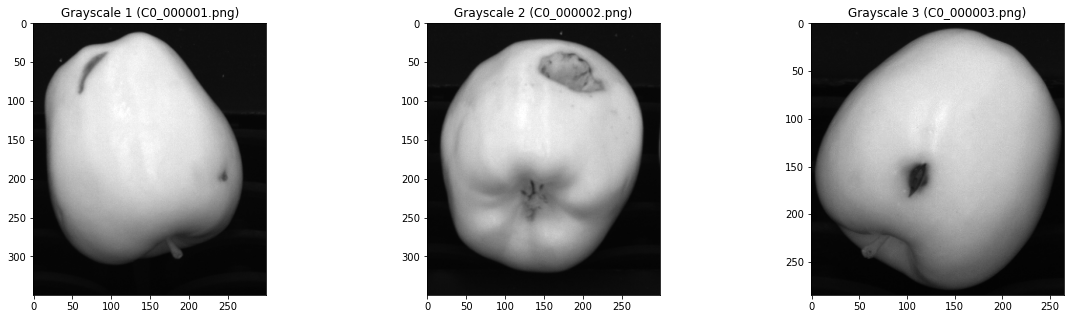

In [20]:
# Import grayscales images acquired through a NIR (Near Infra-Red)
# Then show them

grayscales = []
plt.figure(figsize=(20, 5))

for i, name in enumerate(FILENAMES):
    img = cv2.imread("img/first task/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales.append(img)
    plt.subplot(1,N,i+1)
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

### Fruit segmentation

At first, we want to obtain a binary mask of the fruit for each image, then we will put in evidence imperfections through a floof-fill approach.
In order to do this we will plot the pixel value histogram of each image to see if a thresheold can be easily determined.

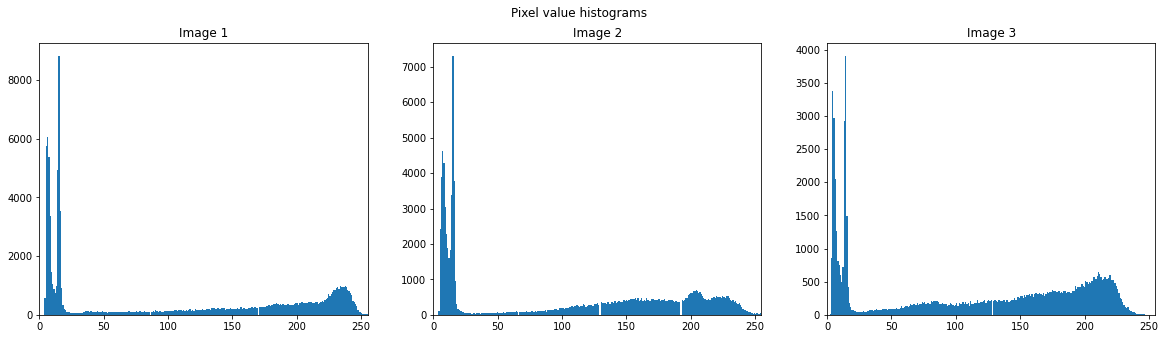

In [21]:
# Plot pixel value histogram of img
def plot_histogram(img, i):
    # flatten to 1D array
    vals = img.flatten()
    # plot histogram with 255 bins
    plt.subplot(1,N,i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])



fig = plt.figure(figsize=(20, 5))
for i, img in enumerate(grayscales):
    plot_histogram(img, i)
fig.suptitle("Pixel value histograms")
plt.show()

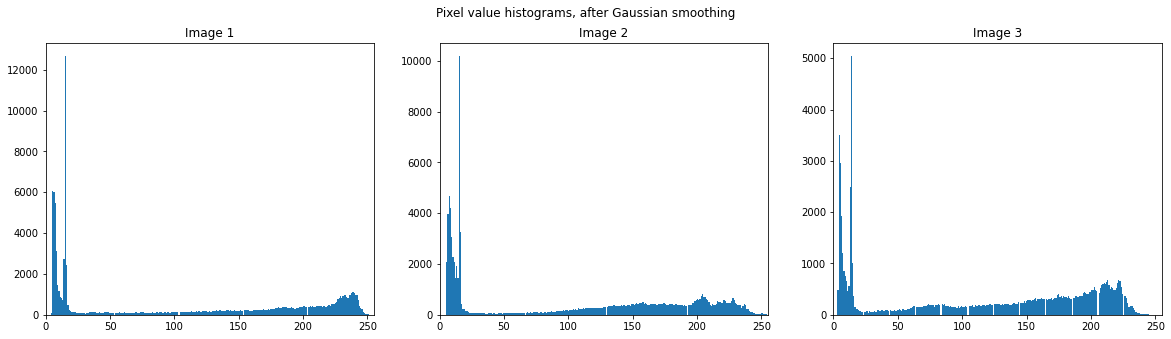

In [22]:
blurred = []
fig = plt.figure(figsize=(20,5))
for i, img in enumerate(grayscales):
    blur = cv2.GaussianBlur(img,(5,5),0)
    blurred.append(blur)
    plot_histogram(blur, i)
fig.suptitle("Pixel value histograms, after Gaussian smoothing")
plt.show()

It is not possible to determine a threshold from the histogram for any of the images, so we need a less naive approach. __Otsu's algorithm__ allow us to obtain the optimal threshold (the one which minimizes the _Within-group Variance_)

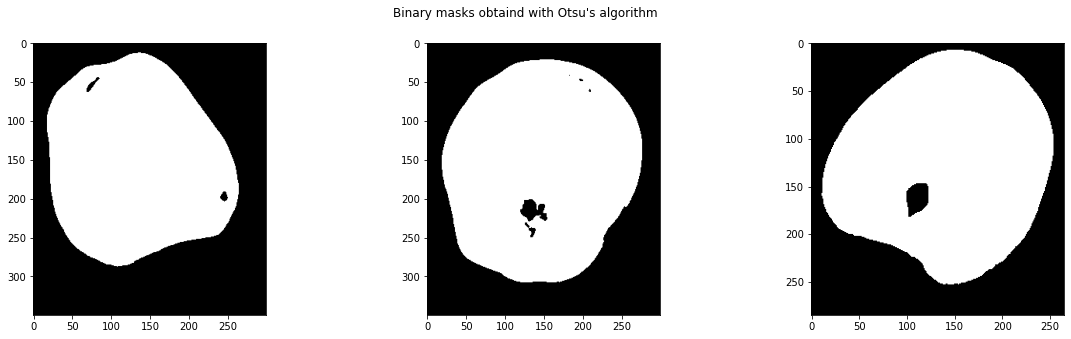

In [23]:
masks = []

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(blurred):
    ret, mask = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    plt.subplot(1,N,i+1)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
fig.suptitle("Binary masks obtaind with Otsu's algorithm")
plt.show()

Now we empirically assume that the left-top corner pixel will always belong to the background, so we can __flood-fill images with seed (0,0)__ to separate the background from the blobs inside fruits

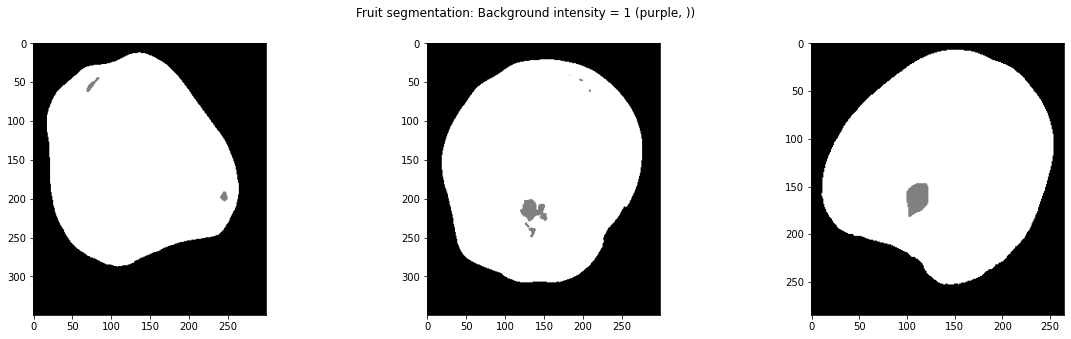

In [28]:
ff_masks = []

fig = plt.figure(figsize=(20,5))
for i, m in enumerate(masks):
    # Add 1 to each pixel, then set the background to 0. Having it set to 0 will simplify further calculus
    ff_m = m + 1
    cv2.floodFill(ff_m, None, (0,0), 0)
    ff_masks.append(ff_m)
    plt.subplot(1,N,i+1)
    plt.imshow(ff_m, cmap="gray", vmin=0, vmax=2)
fig.suptitle("Fruit segmentation: Background intensity = 1 (purple, ))")
plt.show()

Now each image contains information about where the background, the fruit and the "imperfections" are. However in the second image the calyx is classified as an imperfection and the real imperfection, which is lighter than the calyx, is barely visible.
We hope to obtain better results with an edge detection approach.

### Edge detection
To do edge detection we have used Canny's algorithm, which take as parameters two thresholds.
We have tried with differents couple of values (and we have tried to use Gaussian blurred images as well) without find out obtain a perfect and fixed couple which gave perfect results for all the images: with low values the calyx in the second image is detected as-well (__false positive__), on the other hand, with higher values, the calyx disappears, but in the first image the smaller imperfection disappears too (__false negative__).

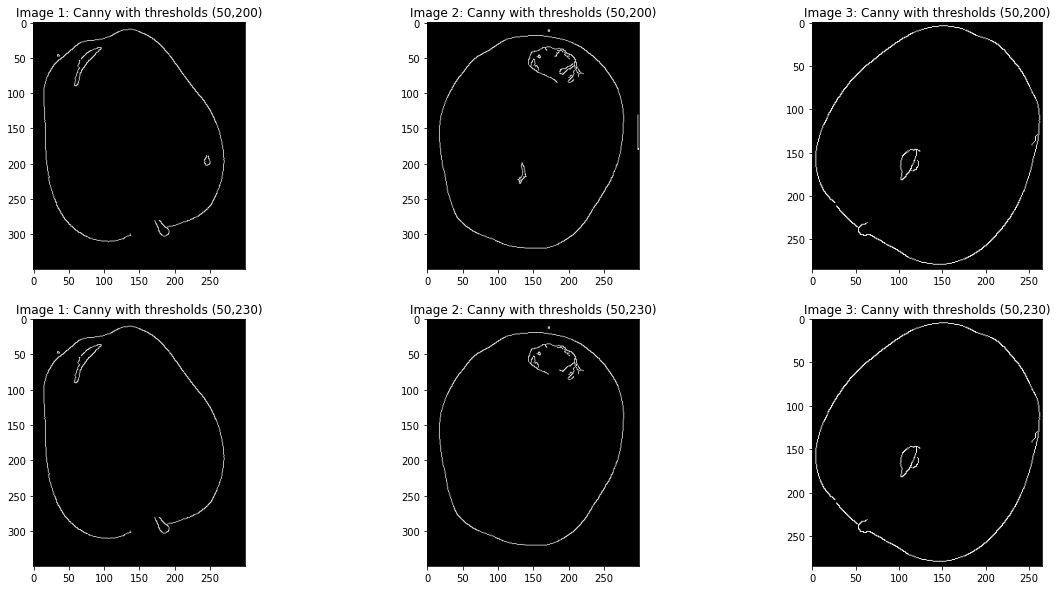

In [65]:
edges_high = []
edges_low = []

plt.figure(figsize=(20,10))
for i, img in enumerate(grayscales):
    edge = cv2.Canny(img, 50, 200)
    edges_low.append(edge)
    plt.subplot(2, N, i+1)
    plt.title("Image {0}: Canny with thresholds (50,200)".format(i+1))
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
    edge = cv2.Canny(img, 50, 230)
    edges_high.append(edge)
    plt.subplot(2, N, i+N+1)
    plt.title("Image {0}: Canny with thresholds (50,230)".format(i+1))
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
plt.show()

We have decided to keep the couple of thresholds that generates false negative, rather than the one that generates false positive. Such decision is motivated by the nature of the problem itself: every apple has a calyx.

So, only the results obtained with the couple _(50,230)_ is used for the following operations.

We now use the masks obtained before to eliminate the edges of the apples and only leave imperfections' edges

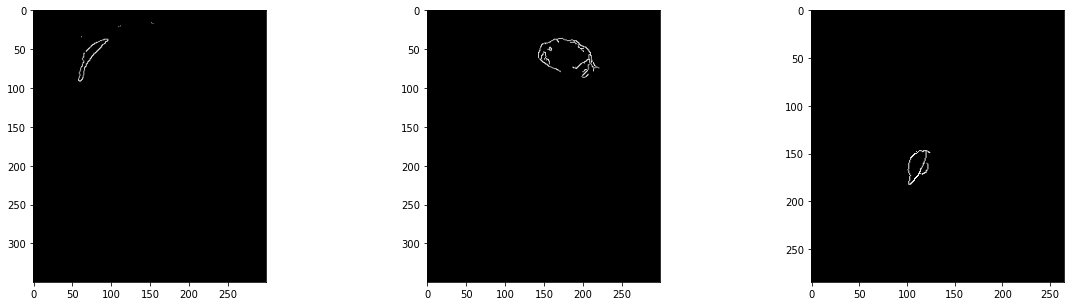

In [69]:
edges = edges_high

plt.figure(figsize=(20,5))
for i, mask in enumerate(ff_masks):
    # We have setted background to 0, so a pixelwise multiplication is sufficient
    edge = edges[i] * mask
    edges[i] = edge
    plt.subplot(1,N,i+1)
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
plt.show()

### Show results on colored images

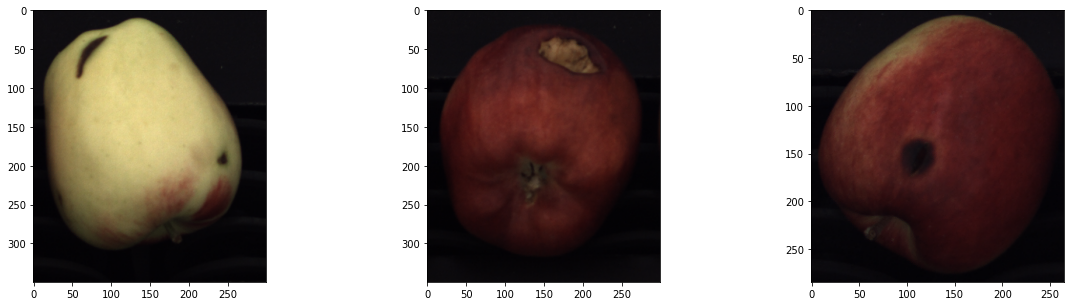

In [70]:
rgb_imgs = []
plt.figure(figsize=(20, 5))
for i, name in enumerate(FILENAMES):
    img_bgr = cv2.imread("img/first task/C1_{0}.png".format(name))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgb_imgs.append(img_rgb)
    plt.subplot(1,N,i+1)
    plt.imshow(img_rgb)
plt.show()

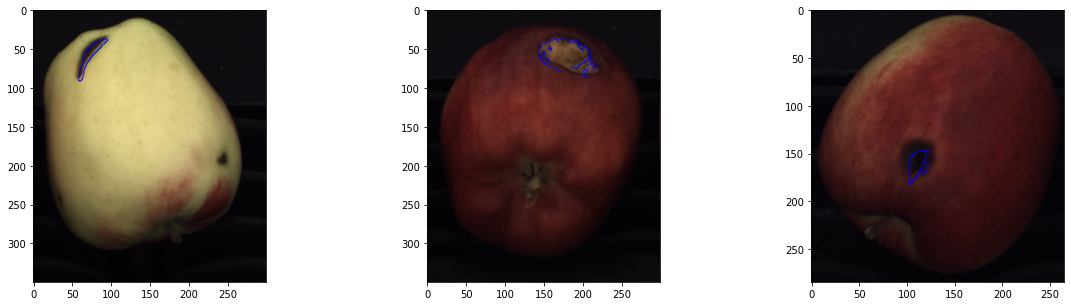

In [71]:
results = []
plt.figure(figsize=(20, 5))
for i, rgb in enumerate(rgb_imgs):
    m, n, _ = rgb.shape
    for j in range(m):
        for k in range(n):
            if edges[i][j,k] != 0:
                rgb[j,k,0] = 0
                rgb[j,k,1] = 0
                rgb[j,k,2] = 255
    results.append(rgb)
    plt.subplot(1,N,i+1)
    plt.imshow(rgb)
plt.show()

Imperfection detected are marked in blue

## Task 2: Russet detection
Images import

In [11]:
FILENAMES2 = ["000004","000005"]
N = len(FILENAMES2)

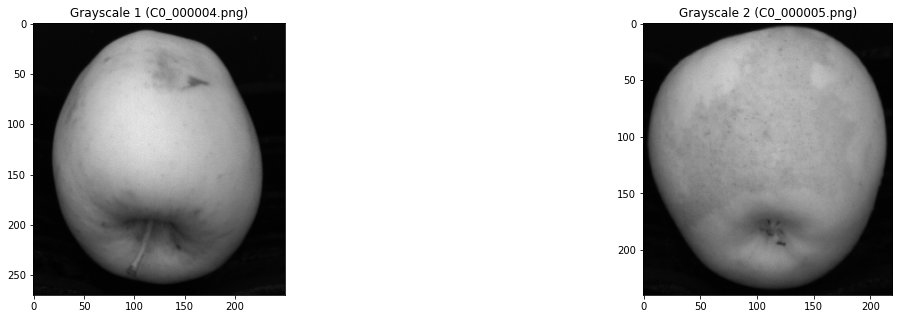

In [12]:
grayscales2 = []
plt.figure(figsize=(20, 5))

for i, name in enumerate(FILENAMES2):
    img = cv2.imread("img/second task/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales2.append(img)
    plt.subplot(1,N,i+1)
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

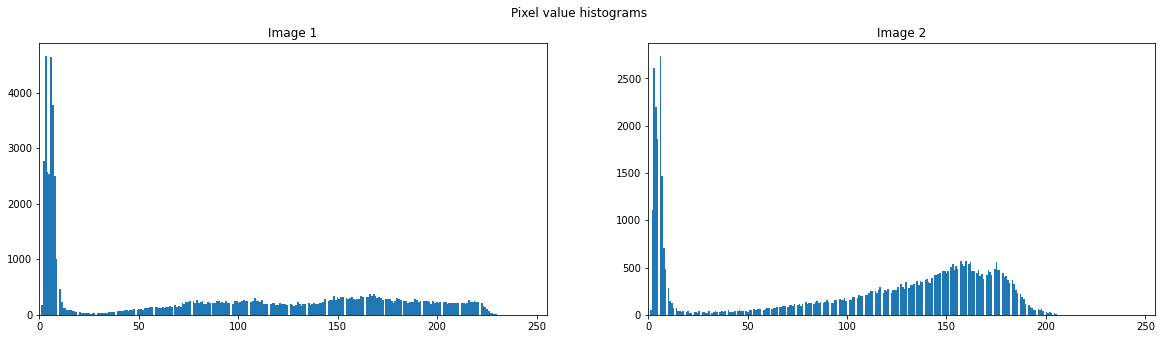

In [13]:
fig = plt.figure(figsize=(20, 5))
for i, img in enumerate(grayscales2):
    # flatten to 1D array
    vals = img.flatten()
    # plot histogram with 255 bins
    plt.subplot(1,N,i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])
fig.suptitle("Pixel value histograms")
plt.show()

We made the histogram to better use the global thresholding to assign to all pixels with values below the threshold T. The threshold T = 40 was selected as the minimum between two modes on a histogram, where pixels with intensity values higher than 40 are shown in white. 

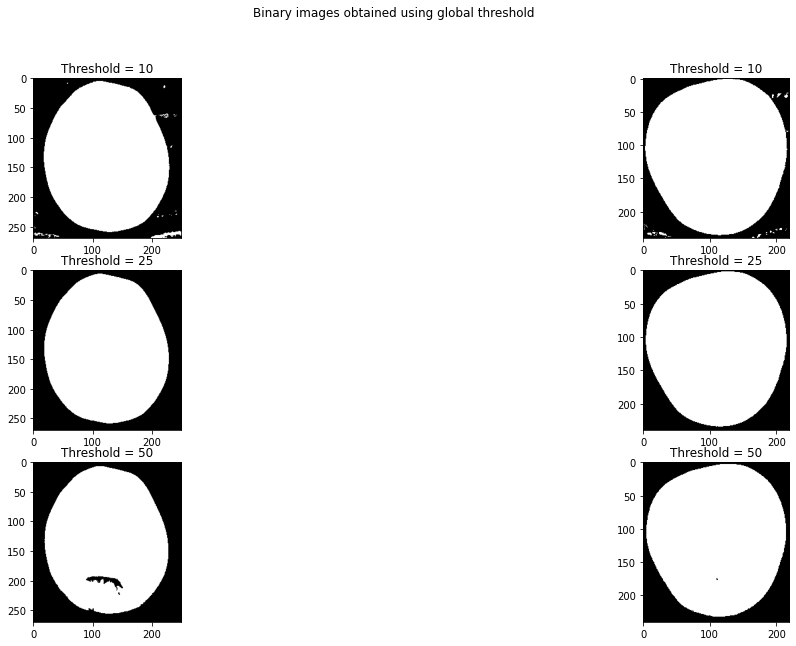

In [15]:
masks2 = []
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(grayscales2):
    # TODO per Vale: spiegare come si è ottenuto threshold uguale a 40 (osservazione istogramma + tentativi),
    # mostrare i risultati con altre threshold, spiegare perché otsu non va bene (il bg "mangia" il fg)
    # aggiungere i titolo al grafico
    ret,thresh = cv2.threshold(img, 10, 1, cv2.THRESH_BINARY)
    ret,thresh1 = cv2.threshold(img, 25, 1, cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(img, 50, 1, cv2.THRESH_BINARY)
    masks2.append(thresh1)
    
    a = fig.add_subplot(3,2, i+1)
    a.set_title('Threshold = 10')
    plt.imshow(thresh, 'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,2,i+3)
    a.set_title('Threshold = 25')
    plt.imshow(thresh1 ,'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,2,i+5)
    a.set_title('Threshold = 50')
    plt.imshow(thresh2 , 'gray' ,vmin=0, vmax=1)
fig.suptitle("Binary images obtained using global threshold")
plt.show()


We also tried to use otsu algorithm but the generated mask we can see that part of the foreground 
has the same color as the background. For this reason we decided to utilize global thresholding.

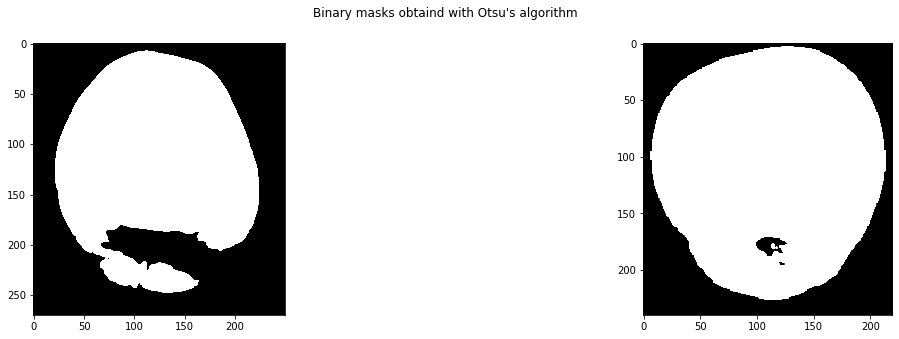

In [16]:
otsu_masks = []

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(grayscales2):
    # (1,1) => no blur
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret, mask = cv2.threshold(blur, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    otsu_masks.append(mask)
    plt.subplot(1,N,i+1)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
fig.suptitle("Binary masks obtaind with Otsu's algorithm")
plt.show()

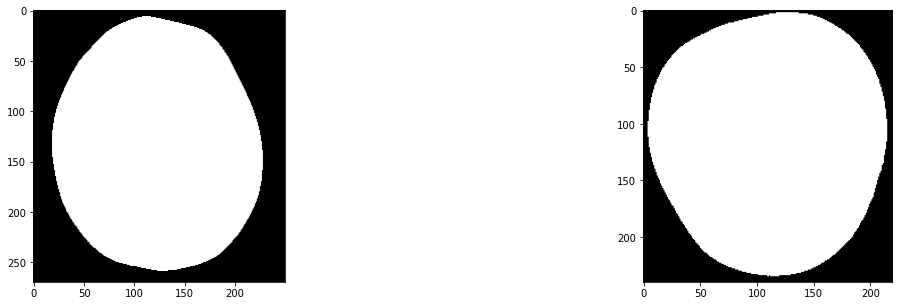

In [17]:
#Flood-fill
ff_masks2 = []
fig = plt.figure(figsize=(20, 5))
for k, mask in enumerate(masks2):
    # Add 1 to each pixel, then set the background to 0. Having it set to 0 will simplify further calculus
    ff_m = mask + 1
    cv2.floodFill(ff_m, None, (0,0), 0)
    m, n = ff_m.shape
    for i in range(m):
        for j in range(n):
            if ff_m[i,j] == 2:
                ff_m[i,j] = 1
    ff_masks2.append(ff_m)
    plt.subplot(1,2,k+1)
    plt.imshow(ff_m, cmap='gray', vmin=0, vmax=1)
plt.show()

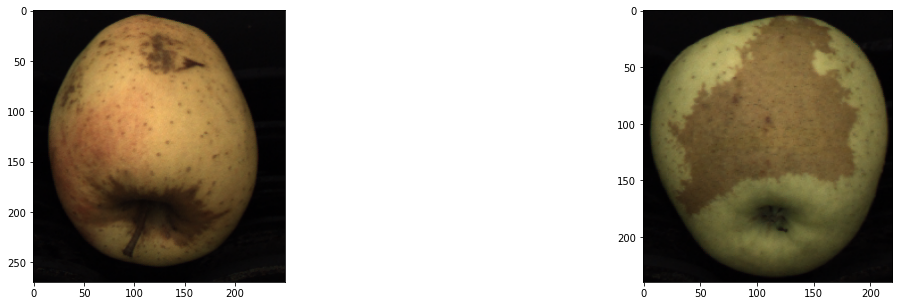

In [18]:
rgb_2 = []
plt.figure(figsize=(20, 5))
for i, name in enumerate(FILENAMES2):
    img_bgr = cv2.imread("img/second task/C1_{0}.png".format(name))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgb_2.append(img_rgb)
    plt.subplot(1,N,i+1)
    plt.imshow(rgb_2[i])
plt.show()

In [62]:
results_2 = []
plt.figure(figsize=(20, 5))
for i, rgb in enumerate(rgb_2):
    m, n, _ = rgb.shape
    result = []
    for j in range(m):
        for k in range(n):
            if masks2[i][j,k] != 0:
                result.append(rgb[j,k,:])
    result = np.array(result)
    results_2.append(result)
    print(result.shape)
    print(result)

"""    
results_3 = []
plt.figure(figsize=(20, 5))
for i, rgb in enumerate(rgb_2):
    m, n, _ = rgb.shape
    for j in range(m):
        for k in range(n):
            if ff_masks2[i][j,k] == 0:
                rgb[j,k,0] = ff_masks2[i][j,k]
                rgb[j,k,1] = ff_masks2[i][j,k]
                rgb[j,k,2] = ff_masks2[i][j,k]
    results_3.append(rgb)
    plt.subplot(1,N,i+1)
    plt.imshow(rgb)
""";

(41254, 3)
[[140 103  57]
 [138 100  55]
 [140 101  56]
 ...
 [  3   2   3]
 [  3   2   3]
 [  3   2   3]]
(38530, 3)
[[ 9  7  9]
 [ 9  7  8]
 [ 8  6  7]
 ...
 [32 30 16]
 [28 28 16]
 [31 30 16]]


<Figure size 1440x360 with 0 Axes>

In [63]:
p_variance_list = []
b = np.array
for i, rgb in enumerate(results_2):
    n, channels = rgb.shape
    means = []
    for j in range(channels):
        mean = np.mean(rgb[:,j])
        means.append(mean)
    cov = []
    for array_i, mean_i in zip(rgb, means):
        for array_j, mean_j in zip(rgb, means):
            cov_ij = np.sum((array_i - mean_i) * (array_j - mean_j))/n
            cov.append(cov_ij)
    print(cov)


[0.1396140288702854, 0.07667523810652334, -0.010131996423330602, 0.07667523810652334, 0.0845898809099005, 0.09669736700199645, -0.010131996423330602, 0.09669736700199645, 0.24691954613903064]
[0.7705200095963759, 0.6713440984637756, 0.35542287707927256, 0.6713440984637756, 0.5849474075198899, 0.3096858995928493, 0.35542287707927256, 0.3096858995928493, 0.16396701553148074]


In [ ]:
'''import sys                      # System bindings                      # OpenCV bindings
import numpy as np
from collections import Counter


class BackgroundColorDetector():
    def __init__(self, imgLoc):
        self.img = cv2.imread(imgLoc, 1)
        self.manual_count = {}
        self.w, self.h, self.channels = self.img.shape
        print(self.w, self.h, self.channels)
        self.total_pixels = self.w*self.h

    def count(self):
        for y in range(0, self.h):
            for x in range(0, self.w):
                RGB = (self.img[x, y, 2], self.img[x, y, 1], self.img[x, y, 0])
                if RGB in self.manual_count:
                    self.manual_count[RGB] += 1
                else:
                    self.manual_count[RGB] = 1

    def average_colour(self):
        red = 0
        green = 0
        blue = 0
        sample = 15
        for top in range(0, sample):
            red += self.number_counter[top][0][0]
            green += self.number_counter[top][0][1]
            blue += self.number_counter[top][0][2]

        average_red = red / sample
        average_green = green / sample
        average_blue = blue / sample
        print("Average RGB for top ten is: (", average_red,
              ", ", average_green, ", ", average_blue, ")")

    def twenty_most_common(self):
        self.count()
        self.number_counter = Counter(self.manual_count).most_common(20)
        for rgb, value in self.number_counter:
            print(rgb, value, ((float(value)/self.total_pixels)*100))

    def detect(self):
        self.twenty_most_common()
        self.percentage_of_first = (
            float(self.number_counter[0][1])/self.total_pixels)
        print(self.percentage_of_first)
        if self.percentage_of_first > 0.5:
            print("Background color is ", self.number_counter[0][0])
        else:
            self.average_colour()


if __name__ == "__main__":
        BackgroundColor = BackgroundColorDetector("img/second task/C1_000005.png")
        BackgroundColor.detect()
'''

we've made the average of the first pixel to find background's color (μ vector)

In [ ]:
'''for i, bgr_image in enumerate(image):
    background_color= image[i][0:240,0:10].mean(axis=0).mean(axis=0)
    plt.imshow(image[i][0:240,0:10])
    plt.show()
    print(background_color)'''